In [5]:

import os
import pandas as pd
import numpy as np

from typing import Literal, Union
from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (roc_curve, roc_auc_score, auc, 
                            precision_recall_curve, classification_report
                            )
from sklearn.model_selection import train_test_split, GridSearchCV



In [98]:

from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.*")

MODEL_MAP = {
    "nb": {
            "name": "Naive Bayes",
            "model": MultinomialNB,
            "hyper_param": "alpha",
        },
    "svc": {
            "name": "Linear SVM",
            "model": svm.LinearSVC,
            "hyper_param": "C"
        }
    }


In [109]:

def show_plots(curve_data, model_name, lw=2):
    
    n = len(curve_data)
    # create subplots
    fig, ax = plt.subplots(1, n)
    # set fig width and title
    fig.set_figwidth(5*n)
    fig.suptitle(f"{model_name} Classifier Model Performance")
    
    for i, (curve_type, data) in enumerate(curve_data.items()):
        # plot curve points
        ax[i].plot(data["x"], data["y"], color='darkorange', lw=lw)
        ax[i].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        
        # Add a text box for the curve score
        ax[i].text(0.6, 0.1,
                s=f'{curve_type.upper()} Score: {data["score"]:.2%}', 
                bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 10})
        
        # set axis bounds
        ax[i].set_xlim([0.0, 1.0])
        ax[i].set_ylim([0.0, 1.05])
        # set axis labels and title
        ax[i].set_xlabel(data["labels"][0])
        ax[i].set_ylabel(data["labels"][1])
        ax[i].set_title(curve_type.upper())
        
    # Adjust layout to prevent overlapping and show plot
    plt.tight_layout()
    plt.show()

def predictions(model_type, model, x_test):
    
    if model_type == "nb":
        # get classification probs and choose "1" class
        pred_probability = model.predict_proba(x_test)[:,1]
        # convert to binary output based on confidence score
        test_predictions = np.where(pred_probability > 0.5, 1, 0)    
    
    elif model_type == "svc":
        # predict test set output
        test_predictions = model.predict(x_test)
        # get probability of guessing each class
        pred_probability = model.decision_function(x_test)
        
    return test_predictions, pred_probability

def vectorize_data(x_test, x_train, stop_words, min_df):
    # initialize and fit the TfidfVectorizer
    vec = TfidfVectorizer(stop_words=stop_words, min_df=min_df)
    vec.fit(x_test)
    # vectorize data
    return vec.transform(x_test), vec.transform(x_train)
    
def fit_model(x_train, y_train,
                model_type: Union[Literal["nb"], Literal["svc"]], 
                algorithm_para=1.0
                ):
    
    # choose classification model and add hyperparams
    model_params = MODEL_MAP[model_type]
    model = model_params["model"](**{ model_params["hyper_param"]: algorithm_para })
    
    # fit classifier model with training data
    model.fit(x_train, y_train)
    
    return model, model_params["name"]

def predict_and_evaluate(model_type, model, x_test, y_test):
    
    curve_data = {
                "auc": {"labels": ("False Positive Rate", "True Positive Rate")}, 
                "prc" :{"labels": ("Recall", "Precision")}
            } 
    
    # predict test set output and get probability of guessing each class
    test_predictions, pred_probability = predictions(model_type, model, x_test)
    
    # print classification report
    print(classification_report(y_test, test_predictions, target_names=['0','1']))

    # get ROC curve using tpr/fpr and calculate AUC score
    fpr, tpr, _ = roc_curve(y_test, pred_probability)
    auc_data = { 
                    "x": fpr, "y": tpr,
                    "score": roc_auc_score(y_test, pred_probability)
                }
    curve_data["auc"].update(auc_data)
    
    # get PRC curve using precision/recall and calculate PRC score
    precision, recall, _ = precision_recall_curve(y_test, pred_probability)
    prc_data =  {
                    "x": recall, "y": precision,
                    "score": auc(recall, precision)
                }
    curve_data["prc"].update(prc_data)

    return curve_data

def classify_data(x_train, y_train, x_test, y_test, model_type, algorithm_para=1.0, min_df=1, stop_words=None):
    
    x_test, x_train = vectorize_data(x_test, x_train, stop_words, min_df)

    model, model_name = fit_model(x_train, y_train, model_type, algorithm_para)
    
    curve_data = predict_and_evaluate(model_type, model, x_test, y_test)
    show_plots(curve_data, model_name)
    
    return curve_data

def search_params(x_train, y_train, vectorizer=TfidfVectorizer(), classifier=svm.LinearSVC()):

    metric = 'f1_macro'
    # initialize search params
    params = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__min_df': [1, 2, 5],
    'clf__C': [0.1, 0.5, 1]
    }
    # create pipeline with vectorizer and classifier
    pipeline = pipeline = Pipeline([
                                     ("tfidf", vectorizer),
                                     ("clf", classifier)
                                   ])

    # return optimal params
    grid = GridSearchCV(pipeline, param_grid=params, scoring=metric, cv=5, n_jobs=-1)
    grid.fit(x_train, y_train)

    min_df = grid.best_params_['tfidf__min_df']
    stop_words = grid.best_params_['tfidf__stop_words']
    C = grid.best_params_['clf__C']

    print("Optimal Grid Search Parameters:\n"
        f"Best f1 score = {grid.best_score_:.3f}\n"
        f"Min. DF = {min_df}\n"
        f"Stopwords = {stop_words}\n"
        f"Classifier Hyper-parameter: {C}\n"
        )
    return min_df, stop_words, C

def sample_size_impact(docs, y, model_type):

    train_size = list(range(1,10))
    train_size.reverse()
    train_size = [i/10 for i in train_size]

    performance = []
    for size in train_size:
        print(f'Training sample size: {(10 - size*10) / 10}')
        # separate into train and test
        x_train, x_test, y_train, y_test = train_test_split(docs, y,  test_size=size, random_state=0)
        
        # calculate auc
        curve_data = classify_data(x_train, y_train, x_test, y_test, model_type)
        performance.append(curve_data["auc"]["score"])

    plt.figure().set_figwidth(5)
    plt.axis((1, 0, 0.8, 1))
    plt.plot(train_size, performance, color='blue', lw=2, label='Model Performance')
    plt.title(f"Impact of Sample Size on {model_type} Classifier Performance")
    plt.xlabel('Testing Sample Percentage')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()


In [7]:

# load sample data
DATA_FILEPATH = os.path.join(os.curdir, "data", "detect.csv")
data=pd.read_csv(DATA_FILEPATH)

# separate into train and test
x_train, x_test, y_train, y_test = train_test_split(data["text"], data["label"], 
                                                    test_size=0.3, 
                                                    random_state=0
                                                    )



In [69]:

model_type = "svc"
# model_type = "nb"

# Impact of Tokenizer

Default Tokenizer



              precision    recall  f1-score   support

           0       0.92      0.87      0.89      2968
           1       0.88      0.93      0.90      3032

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000



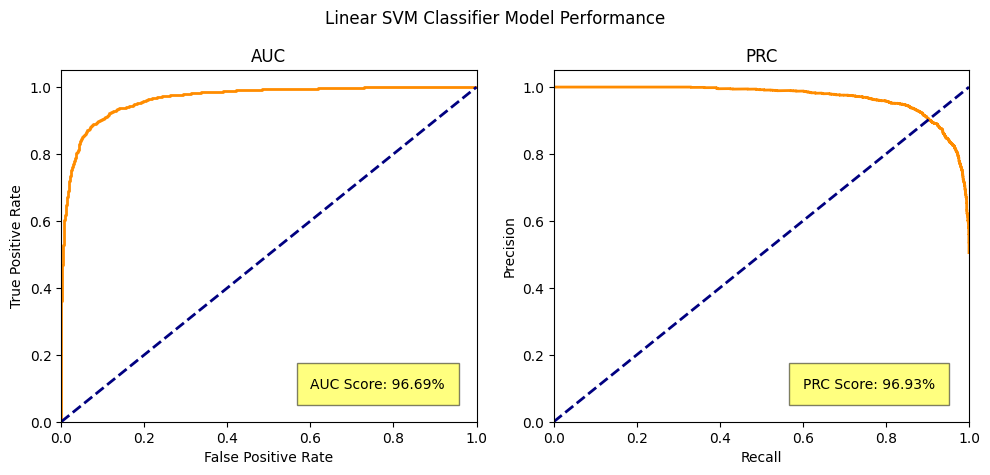

Custom Tokenizer; stopwords = 'english'

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      2968
           1       0.84      0.91      0.88      3032

    accuracy                           0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000



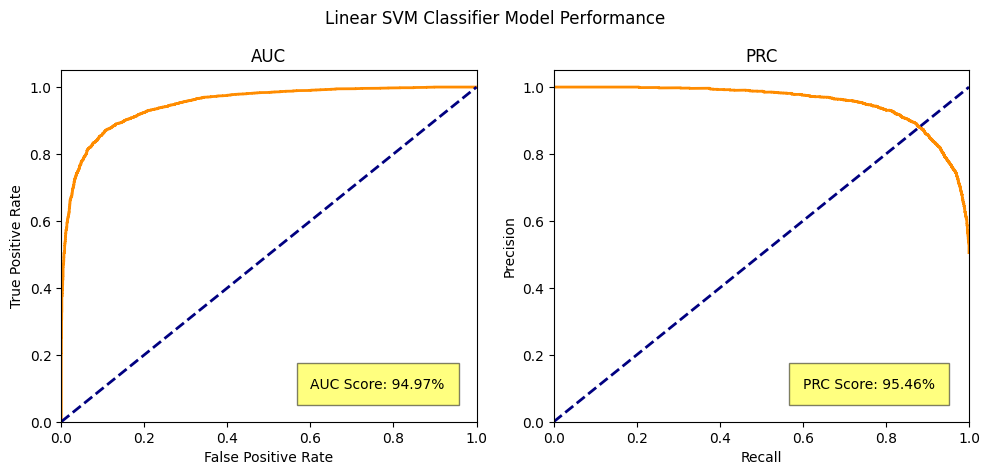

In [102]:

# default tokenizer
print("Default Tokenizer\n")
classify_data(x_train, y_train, x_test, y_test, 
            model_type=model_type, 
            min_df=1, 
            stop_words=None,
            algorithm_para=1.0
            )

# custom tokenizer
print("Custom Tokenizer; stopwords = 'english'\n")
classify_data(x_train, y_train, x_test, y_test, 
            model_type=model_type, 
            min_df=1, 
            stop_words="english",
            algorithm_para=1.0
            )

# Optimize with Grid Search

Optimal Grid Search Parameters:
Best f1 score = 0.911
Min. DF = 5
Stopwords = None
Classifier Hyper-parameter: 0.5

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2968
           1       0.92      0.91      0.92      3032

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.92      0.92      0.92      6000



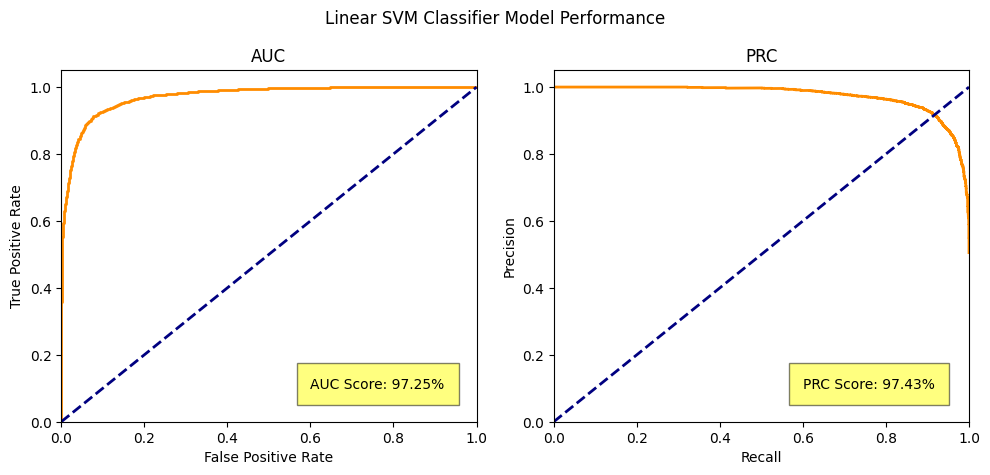

{'auc': {'labels': ('False Positive Rate', 'True Positive Rate'),
  'x': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.36927224e-04,
         3.36927224e-04, 6.73854447e-04, 6.73854447e-04, 1.34770889e-03,
         1.34770889e-03, 1.68463612e-03, 1.68463612e-03, 2.02156334e-03,
         2.02156334e-03, 2.35849057e-03, 2.35849057e-03, 2.69541779e-03,
         2.69541779e-03, 3.03234501e-03, 3.03234501e-03, 3.70619946e-03,
         3.70619946e-03, 4.04312668e-03, 4.04312668e-03, 4.71698113e-03,
         4.71698113e-03, 5.05390836e-03, 5.05390836e-03, 5.39083558e-03,
         5.39083558e-03, 5.72776280e-03, 5.72776280e-03, 6.06469003e-03,
         6.06469003e-03, 6.40161725e-03, 6.40161725e-03, 6.73854447e-03,
         6.73854447e-03, 7.07547170e-03, 7.07547170e-03, 7.41239892e-03,
         7.41239892e-03, 7.74932615e-03, 7.74932615e-03, 8.08625337e-03,
         8.08625337e-03, 8.42318059e-03, 8.42318059e-03, 8.76010782e-03,
         8.76010782e-03, 9.09703504e-03, 9.09703504e-

In [110]:

min_df, stop_words, C = search_params(x_train, y_train)

classify_data(x_train, y_train, x_test, y_test, 
            model_type=model_type, 
            min_df=min_df, 
            stop_words=stop_words,
            algorithm_para=C
            )


# Impact of Sample Size

Training sample size: 0.1
              precision    recall  f1-score   support

           0       0.85      0.80      0.83      8996
           1       0.81      0.86      0.84      9004

    accuracy                           0.83     18000
   macro avg       0.83      0.83      0.83     18000
weighted avg       0.83      0.83      0.83     18000



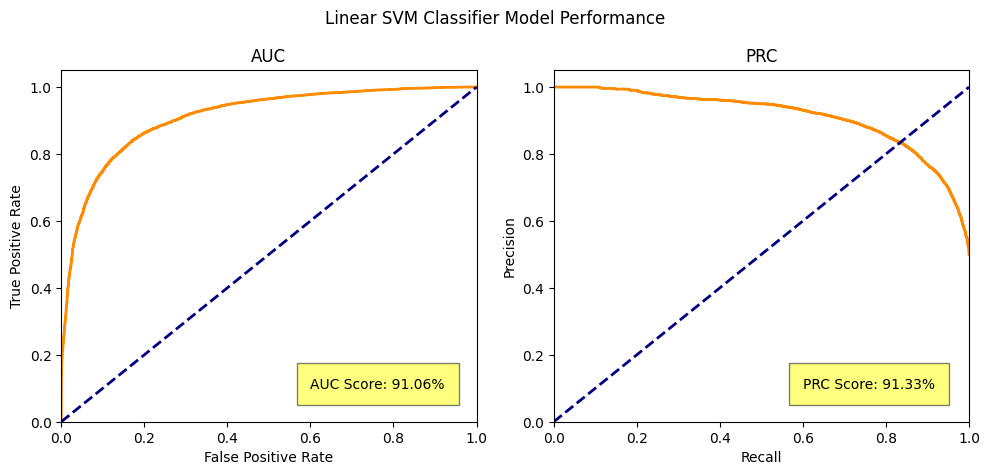

Training sample size: 0.2
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      7966
           1       0.85      0.89      0.87      8034

    accuracy                           0.87     16000
   macro avg       0.87      0.87      0.87     16000
weighted avg       0.87      0.87      0.87     16000



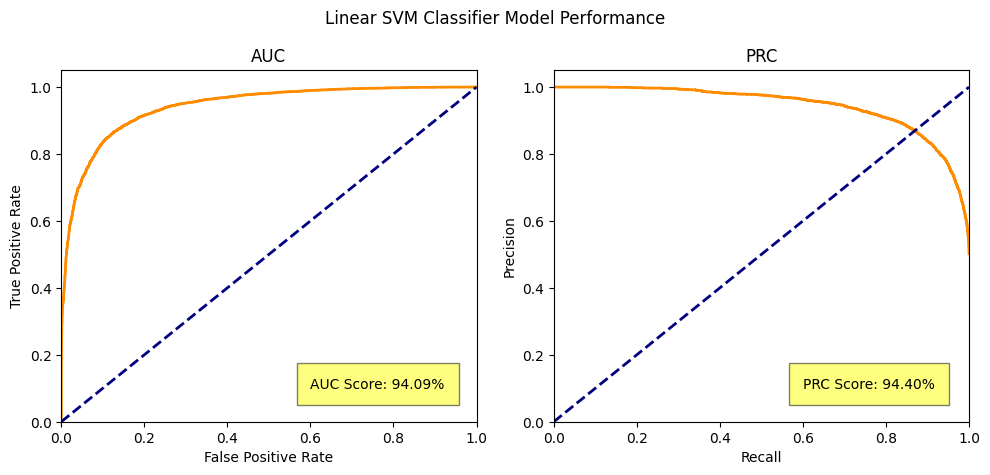

Training sample size: 0.3
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      6985
           1       0.86      0.90      0.88      7015

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



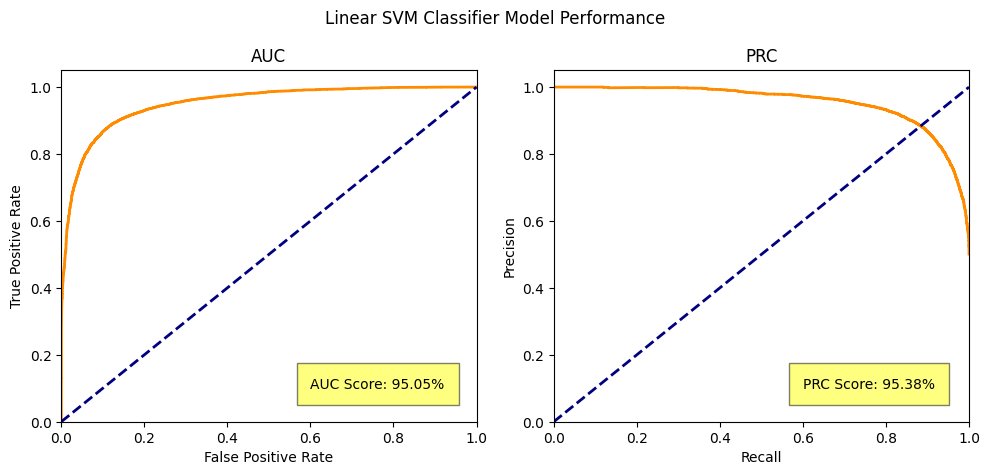

Training sample size: 0.4
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      5959
           1       0.87      0.92      0.89      6041

    accuracy                           0.89     12000
   macro avg       0.89      0.89      0.89     12000
weighted avg       0.89      0.89      0.89     12000



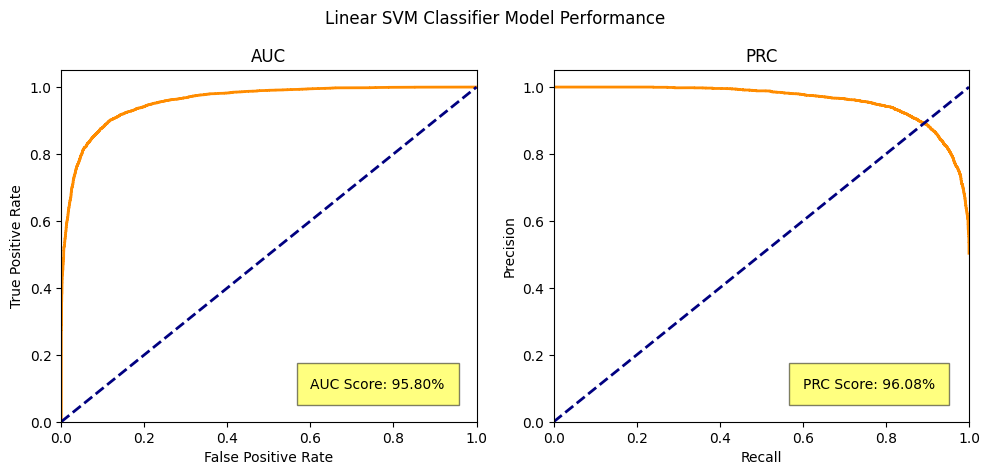

Training sample size: 0.5
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      4976
           1       0.87      0.92      0.90      5024

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



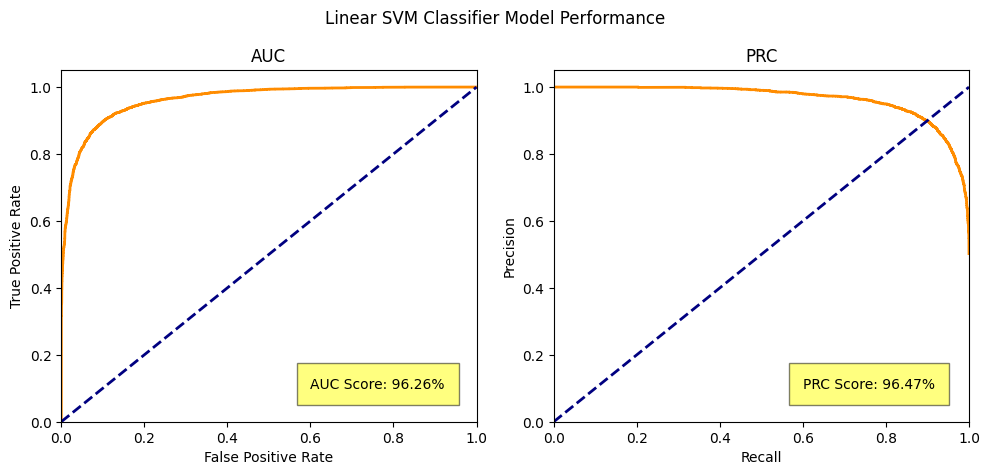

Training sample size: 0.6
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      3967
           1       0.87      0.93      0.90      4033

    accuracy                           0.89      8000
   macro avg       0.90      0.89      0.89      8000
weighted avg       0.90      0.89      0.89      8000



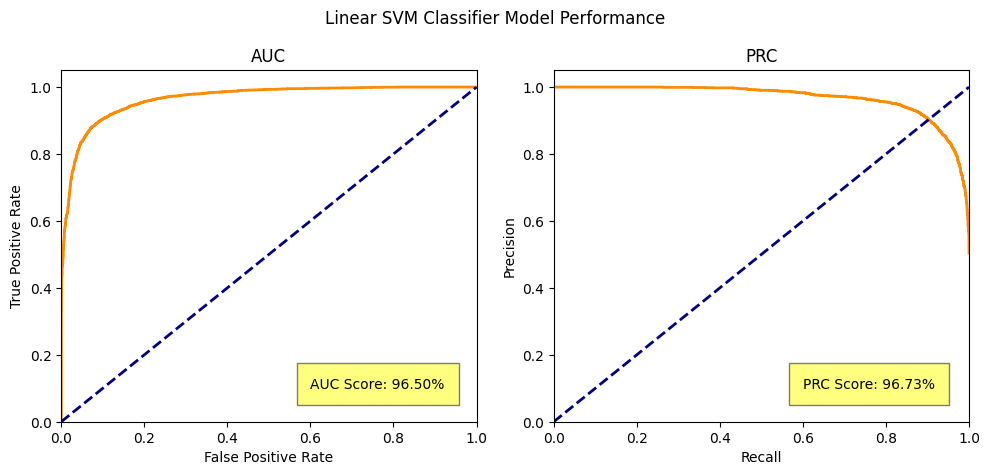

Training sample size: 0.7
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      2968
           1       0.88      0.93      0.90      3032

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000



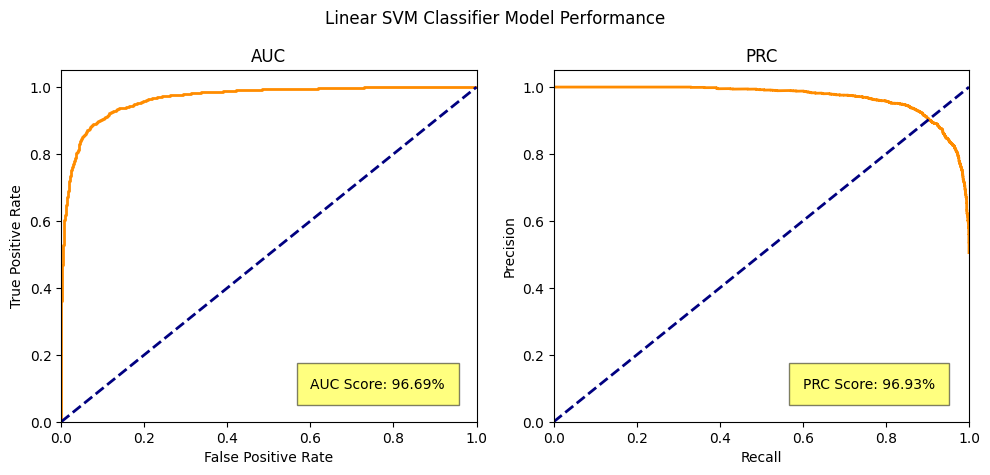

Training sample size: 0.8
              precision    recall  f1-score   support

           0       0.93      0.86      0.90      1966
           1       0.88      0.94      0.91      2034

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



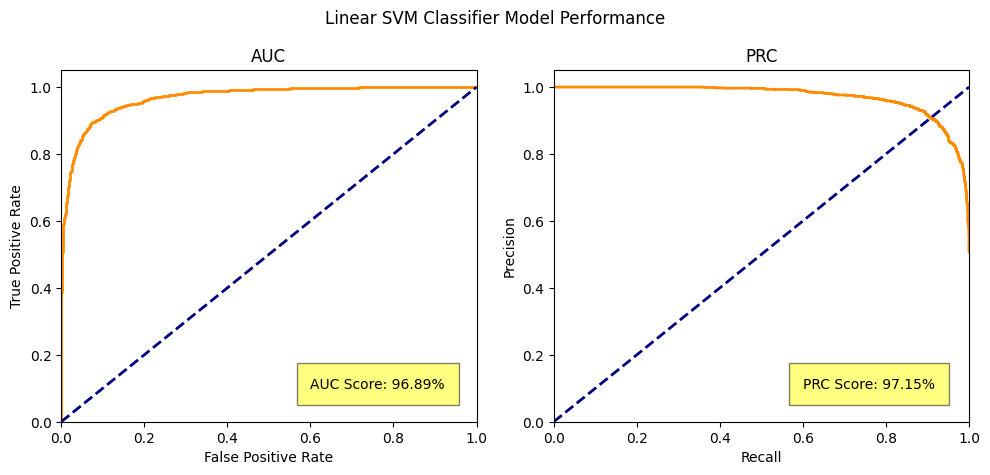

Training sample size: 0.9
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       987
           1       0.88      0.95      0.91      1013

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



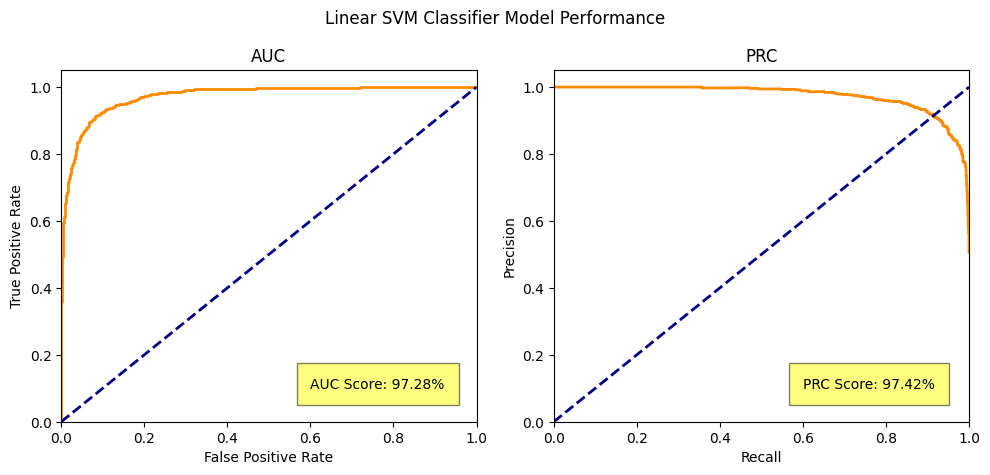

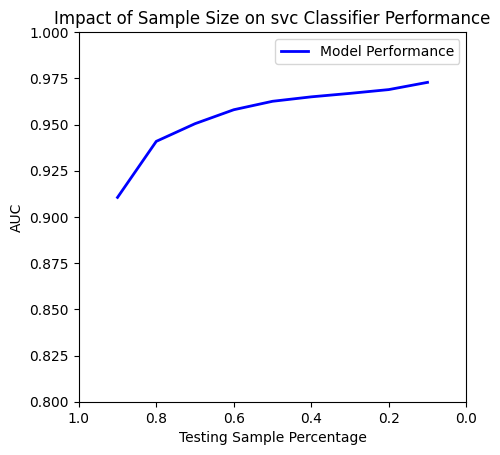

In [111]:

sample_size_impact(data["text"], data["label"], model_type)
